# Seperating stock to forcast for certain dates depending on the product

In [ ]:
%pip install nbformat

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# # import datasets and transformations (reusability purposes)
# from IPython import get_ipython

# get_ipython().run_line_magic('run', 'datasets.ipynb')

In [ ]:
import sys
sys.path.append('../src')

In [ ]:
from data_config import ProductHandler as ph

In [ ]:
ph.custom_prod_set()

In [ ]:
# # display the highest order quantity customers 
# ph.highest_customs()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# define the features and target variable from 'product_sales'
# CHANGE THE CUSTOMER CODE HERE >>>>>>>>>>
custom_code_df = pd.DataFrame(ph.get_custom_code_data('UND'))

# customer code for later referencing
custom_ref = custom_code_df.loc[0, 'ProductNumber'][:3].lower().upper()
print(custom_ref)

custom_code_df.head()

In [ ]:
ph.feature_importance(custom_code_df)

In [ ]:
from scipy import stats

# Define a function to compute z-scores within each product group
def compute_zscore(group, threshold=3):
    # Only compute z-score if there are at least 2 data points in the group
    if len(group) >= 2:
        group['z_score'] = np.abs(stats.zscore(group['OrderQuantity']))
    else:
        group['z_score'] = 0  # or np.nan if preferred
    return group

# Group by "ProductNumber" and compute z-scores for "OrderQuantity" within each group
df_grouped = custom_code_df.groupby('ProductNumber').apply(compute_zscore)

# Define your threshold for what constitutes an "unusually high" order
z_threshold = 3

# Filter for outliers (orders with a z_score greater than the threshold)
df_outliers = df_grouped[df_grouped['z_score'] > z_threshold]

# Display the results
print("Unusually high order quantities (per ProductNumber):")
print(df_outliers[['ProductNumber', 'OrderQuantity', 'z_score']])

print(f'Dropping: \n{df_outliers.count()}')
# Keep only rows where the z-score is within the acceptable range
df_cleaned = df_grouped[df_grouped['z_score'] <= z_threshold].drop(columns=['z_score'])

# Reset index for clarity
df_cleaned.reset_index(drop=True, inplace=True)

custom_code_df = df_cleaned


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
df = custom_code_df

features = ['ProductNumber', 'order_month',
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
            ]
target = 'OrderQuantity'

X = df[features]
y = df[target]

# one-hot encoding for categorical features
categorical_features = ['ProductNumber']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# preprocessor (keeps numerical features as is)
preprocessor = ColumnTransformer(
    transformers=[
        # one-hot encode categorical features
        ('cat', encoder, categorical_features)
    ], remainder='passthrough'
)

# transform the features
X_transformed = preprocessor.fit_transform(X)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
customer_total = df.copy()

# define features and target
features = ['ProductNumber', 'order_month', 'order_week', 'order_weekday',
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
           ]
target = 'OrderQuantity'

# filter the top products
total_X = customer_total[features]  # Features from top products
total_y = customer_total[target]    # Target variable

# define categorical and numeric features
categorical_features = ['ProductNumber']
numeric_features = list(set(features) - set(categorical_features))  # All other features are numeric

# Define transformations
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features),   # One-hot encode categorical features
        ('num', scaler, numeric_features)        # Standardize numeric features
    ]
)

# Train-test split
total_X_train, total_X_val, total_y_train, total_y_val = train_test_split(total_X, total_y, test_size=0.2, random_state=42)

# Transform the features
total_X_train_transformed = preprocessor.fit_transform(total_X_train)
total_X_val_transformed = preprocessor.transform(total_X_val)

# Output the shape
print(f"Train Shape: {total_X_train_transformed.shape}, Validation Shape: {total_X_val_transformed.shape}")
print("Feature processing for top products completed successfully!")

customer_total.head()


In [ ]:
# the top 10 (or change) products by total actual order quantity
top_products = df.groupby('ProductNumber')['OrderQuantity'].sum().nlargest(1)

# extract top product code rows from the original df
top_prods_df = df[df['ProductNumber'].isin(top_products.index)]

# Extract top product numbers
top_product_numbers = top_products.index.tolist()  # List of top product numbers

top_prods_df.head()

unique_order_years = custom_code_df['order_year'].unique()
print(unique_order_years)

In [ ]:
# define features and target
features = ['ProductNumber', 'order_month', 
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
           ]
target = 'OrderQuantity'

# filter the top products
tp_X = top_prods_df[features]  # Features from top products
tp_y = top_prods_df[target]    # Target variable

# define categorical and numeric features
categorical_features = ['ProductNumber']
numeric_features = list(set(features) - set(categorical_features))  # All other features are numeric

# Define transformations
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features),   # One-hot encode categorical features
        ('num', scaler, numeric_features)        # Standardize numeric features
    ]
)

# Train-test split
tp_X_train, tp_X_val, tp_y_train, tp_y_val = train_test_split(tp_X, tp_y, test_size=0.2, random_state=42)

# Transform the features
tp_X_train_transformed = preprocessor.fit_transform(tp_X_train)
tp_X_val_transformed = preprocessor.transform(tp_X_val)

# Output the shape
print(f"Train Shape: {tp_X_train_transformed.shape}, Validation Shape: {tp_X_val_transformed.shape}")
print("Feature processing for top products completed successfully!")


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from model_utils import *

In [ ]:
# train the model with scaled features (Random Forest Regressor)
rf = RandomForestRegressor()
rf_params = find_best_hyperparameters(rf, param_grids(rf.__class__.__name__), X_train_scaled, y_train)

In [ ]:
rf = RandomForestRegressor(**rf_params)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_val_scaled)

In [ ]:
print('---------------------- TRAINING PERFORMANCE ----------------------')
evaluate_model(rf, X_train_scaled, y_train)
print('--------------------------------------------')

print('---------------------- TEST PERFORMANCE ----------------------')
evaluate_model(rf, X_val_scaled, y_val)
print('--------------------------------------------')

In [ ]:
# train the model with scaled features (Random Forest Regressor) - TOTAL CUSTOM PRODUCTS IMPLEMENTATION
total_rf = RandomForestRegressor()
total_rf_params = find_best_hyperparameters(total_rf, param_grids(total_rf.__class__.__name__), total_X_train_transformed, total_y_train)

In [ ]:
total_rf = RandomForestRegressor(**total_rf_params)
total_rf.fit(total_X_train_transformed, total_y_train)
total_y_pred_rf = total_rf.predict(total_X_val_transformed)

In [ ]:
print('---------------------- TRAINING PERFORMANCE ----------------------')
evaluate_model(total_rf, total_X_train_transformed, total_y_train)
print('--------------------------------------------')

print('---------------------- TEST PERFORMANCE ----------------------')
evaluate_model(total_rf, total_X_val_transformed, total_y_val)
print('--------------------------------------------')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print(y_pred_rf.tolist())

plt.figure(figsize=(10, 6))

# scatter plot, actual vs predicted values
sns.scatterplot(x=y_val, y=y_pred_rf, alpha=0.4, color='blue', label='Predicted')  # Predicted values in blue

# actual values in red
sns.scatterplot(x=y_val, y=y_val, alpha=0.4, color='#f26d1d', label='Actual')

# reference line for perfect prediction
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='black', label="Perfect Prediction")

plt.xlabel("Actual Order Quantity")
plt.ylabel("Predicted Order Quantity")
plt.title(f"{custom_ref} - Predicted vs. Actual Order Quantity (Random Forest)")
plt.legend()

plt.show()

In [ ]:
# Convert order year and month to datetime format
top_prods_df['OrderDate'] = pd.to_datetime(top_prods_df[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))

# Sort by OrderDate to maintain time order
top_prods_df = top_prods_df.sort_values(by='OrderDate')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Bar plot, actual and predicted values over time
axes[0].bar(df.loc[y_val.index, 'ProductNumber'], y_val, label='Actual', alpha=0.6)
axes[0].bar(df.loc[y_val.index, 'ProductNumber'], y_pred_rf, label='Predicted', alpha=0.6)
axes[0].set_xlabel('Product Number')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity (Bar plot)')
axes[0].set_ylim(0, 1250000)
axes[0].legend()

# Line plot, actual and predicted values
sorted_indices = df.loc[y_val.index, 'ProductNumber'].argsort()
sorted_products = df.loc[y_val.index, 'ProductNumber'].iloc[sorted_indices]
sorted_actual = y_val.iloc[sorted_indices]
sorted_predicted = y_pred_rf[sorted_indices]

axes[1].plot(sorted_products, sorted_actual, label='Actual', alpha=0.6, marker='o')
axes[1].plot(sorted_products, sorted_predicted, label='Predicted', alpha=0.6, marker='x')
axes[1].set_xlabel('Product Number')
axes[1].set_ylabel('Order Quantity')
axes[1].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity (Line plot)')
axes[1].set_ylim(0, 1250000)
axes[1].legend()

# Residual plot
residuals = y_val - y_pred_rf
axes[2].scatter(df.loc[y_val.index, 'ProductNumber'], residuals, alpha=0.6)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Product Number')
axes[2].set_ylabel('Residuals')
axes[2].set_title(f'{custom_ref} - Residual Plot')

plt.tight_layout()
plt.show()


In [ ]:
# Convert order year and month to datetime format
customer_total['OrderDate'] = pd.to_datetime(customer_total[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))

# Sort by OrderDate to maintain time order
customer_total = customer_total.sort_values(by='OrderDate')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Bar plot, actual and predicted values over time
axes[0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_val, label='Actual', alpha=0.6)
axes[0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_pred_rf, label='Predicted', alpha=0.6)
axes[0].set_xlabel('Order Date')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity Over Time')
axes[0].set_ylim(0, 3000000)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Line plot, actual and predicted values over time
sorted_indices = top_prods_df.loc[tp_y_val.index, 'OrderDate'].argsort()
sorted_dates = top_prods_df.loc[tp_y_val.index, 'OrderDate'].iloc[sorted_indices]
sorted_actual = total_y_val.iloc[sorted_indices]
sorted_predicted = total_y_pred_rf[sorted_indices]

axes[1].plot(sorted_dates, sorted_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
axes[1].plot(sorted_dates, sorted_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')
axes[1].set_xlabel('Order Date')
axes[1].set_ylabel('Order Quantity')
axes[1].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity Over Time')
axes[1].set_ylim(0, 3000000)
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# Residual plot over time
residuals = total_y_val - total_y_pred_rf
axes[2].scatter(customer_total.loc[total_y_val.index, 'OrderDate'], residuals, alpha=0.6)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Order Date')
axes[2].set_ylabel('Residuals')
axes[2].set_title(f'{custom_ref} - Residual Plot Over Time')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# # to see dataframe structure
# customer_total.head()


In [ ]:
# # to see prediction nparray structure
# total_y_pred_rf

In [ ]:
# # Group data by OrderDate and sum the relevant numerical columns
# customer_total = top_prods_df.groupby('OrderDate').sum(numeric_only=True).reset_index()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust layout for better spacing

# Bar plot: Actual vs. Predicted Order Quantity
axes[0, 0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_val, label='Actual', alpha=0.6)
axes[0, 0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_pred_rf, label='Predicted', alpha=0.6)
axes[0, 0].set_xlabel('Order Date')
axes[0, 0].set_ylabel('Order Quantity')
axes[0, 0].set_title(f'{custom_ref} Total Products - Actual vs Predicted (Bar Plot)')
axes[0, 0].set_ylim(0, 1_000_000)
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Residual Plot
residuals = total_y_val - total_y_pred_rf
axes[0, 1].scatter(customer_total.loc[total_y_val.index, 'OrderDate'], residuals, alpha=0.6)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Order Date')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title(f'{custom_ref} Total Products - Residual Plot')
axes[0, 1].tick_params(axis='x', rotation=45)

# Pie Chart: Order Quantity per Month (2024)
order_2024 = customer_total[customer_total['order_year'] == 2024].groupby('order_month')['OrderQuantity'].sum()
axes[0, 2].pie(order_2024, labels=order_2024.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[0, 2].set_title(f'{custom_ref} Order Quantity Distribution (2024)')

# Line Plots: Yearly Trends
for i, year in enumerate([2022, 2023, 2024]):  
    yearly_df = customer_total[customer_total['order_year'] == year]

    if yearly_df.empty:
        continue  # skip if no data for that year

    # Aggregate OrderQuantity per month
    monthly_actual = yearly_df.groupby('order_month')['OrderQuantity'].sum()

    # Convert total_y_pred_rf to Pandas Series with index from customer_total
    pred_series = pd.Series(total_y_pred_rf, index=total_y_val.index)

    # Group predictions by month
    monthly_predicted = pred_series.groupby(customer_total.loc[total_y_val.index, 'order_month']).sum()

    # Sort for proper plotting
    monthly_actual = monthly_actual.sort_index()
    monthly_predicted = monthly_predicted.reindex(monthly_actual.index)  # Ensure same months

    # Plot actual and predicted values for the year
    axes[1, i].plot(monthly_actual.index, monthly_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
    axes[1, i].plot(monthly_predicted.index, monthly_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')

    axes[1, i].set_xlabel('Month')
    axes[1, i].set_ylabel('Order Quantity')
    axes[1, i].set_title(f'{custom_ref} {year} Total Products - Actual vs Predicted')
    axes[1, i].set_ylim(0, max(monthly_actual.max(), monthly_predicted.max()) * 1.1)  # Scale Y axis
    axes[1, i].legend()
    axes[1, i].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


In [ ]:
has_orders_2022 = not customer_total[customer_total['order_year'] == 2022].empty
print(f"Orders in 2022 exist: {has_orders_2022}")


In [ ]:
customer_total.head(10)

In [ ]:
# from powerbiclient import QuickVisualize, get_dataset_config, Report
# from powerbiclient.authentication import InteractiveLoginAuthentication, DeviceCodeLoginAuthentication
# import pandas as pd

# prod_sales = pd.read_csv(
#     '/Users/mwilko777/Desktop/Project/Software Artifact/datasets/stock_forecasting/final/product_sales.csv')

# # use DeviceCodeLoginAuthentication if want to sign in each time, else InteractiveLoginAuthentication
# auth = InteractiveLoginAuthentication()
# print("Authentication successful.")


# def visual():
#     dataset_config = get_dataset_config(prod_sales)
#     return QuickVisualize(dataset_config, auth)

# visual()

In [ ]:
customer_total.head()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a DetailedOrderDate column using week and weekday information.
customer_total['DetailedOrderDate'] = pd.to_datetime(
    customer_total['order_year'].astype(str) +
    customer_total['order_week'].astype(str).str.zfill(2) +
    customer_total['order_weekday'].astype(str),
    format='%Y%W%w'
)

# Filter the data for December 2024 using DetailedOrderDate
dec_2024_data = customer_total[
    (customer_total['DetailedOrderDate'].dt.year == 2024) &
    (customer_total['DetailedOrderDate'].dt.month == 12)
]

# Use only the common indices between dec_2024_data and y_val
common_index = dec_2024_data.index.intersection(y_val.index)
dec_2024_actual = y_val.loc[common_index]
# Convert y_pred_rf to a Series for indexing (using the same index as y_val)
y_pred_rf_series = pd.Series(y_pred_rf, index=y_val.index)
dec_2024_predicted = y_pred_rf_series.loc[common_index]

# --- Incorporate your provided sorting snippet, adapted for December 2024 data ---
# Here we sort by DetailedOrderDate from dec_2024_data for the common indices.
sorted_indices = dec_2024_data.loc[common_index, 'DetailedOrderDate'].argsort()
sorted_dates = dec_2024_data.loc[common_index, 'DetailedOrderDate'].iloc[sorted_indices]
sorted_actual = dec_2024_actual.iloc[sorted_indices]
sorted_predicted = dec_2024_predicted.iloc[sorted_indices]
# --- End of sorting snippet ---

# Create subplots (1 row, 2 columns: one for line plot, one for residual plot)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Line Plot: Actual vs. Predicted Order Quantity using DetailedOrderDate
axes[0].plot(sorted_dates, sorted_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
axes[0].plot(sorted_dates, sorted_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')
axes[0].set_xlabel('Detailed Order Date')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - December 2024 Actual vs Predicted (Line Plot)')
axes[0].set_ylim(0, 1_500_000)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Residual Plot for December 2024
residuals_dec_2024 = sorted_actual - sorted_predicted
axes[1].scatter(sorted_dates, residuals_dec_2024, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Detailed Order Date')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'{custom_ref} - December 2024 Residual Plot')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

# check dataset shape
print("x_train shape:", X_train.shape)
print("x_val shape:", X_val.shape)

# convert x_train to dataframe if needed
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)
    X_val = pd.DataFrame(X_val)

# separate numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

# preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# transform data
X_train_transformed = preprocessor.fit_transform(X_train)
print(f"Original features: {X_train.shape[1]}")
print(f"Transformed features: {X_train_transformed.shape[1]}")

X_val_transformed = preprocessor.transform(X_val)
X_val_scaled = np.array(X_val_transformed)

# convert sparse matrices if necessary
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()
    X_val_transformed = X_val_transformed.toarray()

# ensure numpy array format
X_train_scaled = np.array(X_train_transformed)
X_val_scaled = np.array(X_val_transformed)
if X_train_scaled.ndim == 1:
    X_train_scaled = X_train_scaled.reshape(-1, 1)
if X_val_scaled.ndim == 1:
    X_val_scaled = X_val_scaled.reshape(-1, 1)

# define neural network model
def create_nn_model(input_shape):
    model = Sequential([
        Dense(64, input_dim=input_shape, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

input_shape = X_train_scaled.shape[1]

# set hyperparameter grid
def param_grids():
    return {
        'epochs': [10, 20, 30],
        'batch_size': [16, 32, 64]
    }

# wrap model for sklearn compatibility
nn_model = KerasRegressor(build_fn=create_nn_model, input_shape=input_shape, verbose=1)

grid_search = RandomizedSearchCV(
    estimator=nn_model, 
    param_distributions=param_grids(),
    n_iter=10, 
    cv=3,
    n_jobs=-1, 
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

# train final model with best parameters
nn_params = grid_search.best_params_
best_nn_model = create_nn_model(input_shape)
best_nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

best_nn_model.fit(
    X_train_scaled, y_train,
    epochs=nn_params['epochs'], 
    batch_size=nn_params['batch_size'], 
    validation_split=0.2,
    verbose=1
)

# make predictions
y_pred_nn = best_nn_model.predict(X_val_scaled)

evaluate_model_nn(best_nn_model, X_val_scaled, y_val)

In [ ]:
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")


In [ ]:
print(f"X_train shape before scaling: {X_train.shape}")
print(f"y_train shape before scaling: {y_train.shape}")


In [ ]:
from sklearn.ensemble import VotingRegressor

rf_nn_voting = VotingRegressor(estimators=[('rf', RandomForestRegressor(**rf_params)), ('nn', KerasRegressor(build_fn=create_nn_model, input_shape=input_shape, **nn_params))])
rf_nn_voting.fit(X_train_scaled, y_train)
y_pred_rf_nn_voting = rf_nn_voting.predict(X_val_scaled)

In [46]:
print('---------------------- TRAINING PERFORMANCE ----------------------')
evaluate_model(rf_nn_voting, X_train_scaled, y_train)
print('--------------------------------------------')

---------------------- TRAINING PERFORMANCE ----------------------
Evaluating model...
Model: VotingRegressor
Epoch 1/30


/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - loss: 170439393280.0000 - mean_absolute_error: 154510.2500 
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 119617216512.0000 - mean_absolute_error: 134859.8125
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 136593285120.0000 - mean_absolute_error: 137384.4531
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 133510250496.0000 - mean_absolute_error: 141076.5156
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 109780918272.0000 - mean_absolute_error: 127836.0078
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 131773267968.0000 - mean_absolute_error: 139725.5000
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 102219595776.0000 - mean_absolute_error: 128268.3203
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 102226567168.0000 - mean_absolute_error: 122344.5391
Epoch 9/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 135045971968.0000 - mean_absol

/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - loss: 204214321152.0000 - mean_absolute_error: 162693.4844
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 143644639232.0000 - mean_absolute_error: 147596.8125
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 117994348544.0000 - mean_absolute_error: 140521.1250
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 228400021504.0000 - mean_absolute_error: 161021.3906
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 120426315776.0000 - mean_absolute_error: 132175.1250
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 87227449344.0000 - mean_absolute_error: 125253.2109
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 92897648640.0000 - mean_absolute_error: 120706.5312
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 86175547392.0000 - mean_absolute_error: 115631.0078
Epoch 9/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 138527735808.0000 - mean_absolut

/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step - loss: 172107694080.0000 - mean_absolute_error: 154283.8750 
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 148677246976.0000 - mean_absolute_error: 144693.8438
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 122642235392.0000 - mean_absolute_error: 136304.2031
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 152187994112.0000 - mean_absolute_error: 142875.0000
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 143475621888.0000 - mean_absolute_error: 138993.7656
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 108759048192.0000 - mean_absolute_error: 124245.4297
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 161171849216.0000 - mean_absolute_error: 145502.1875
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 155406942208.0000 - mean_absolute_error: 126686.4141
Epoch 9/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 147740835840.0000 - mean_abs

/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - loss: 109618642944.0000 - mean_absolute_error: 138645.0156
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 115475333120.0000 - mean_absolute_error: 132170.0312
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 126485667840.0000 - mean_absolute_error: 134390.1562
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 157984456704.0000 - mean_absolute_error: 149257.1719
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 123478892544.0000 - mean_absolute_error: 135253.3281
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 119502741504.0000 - mean_absolute_error: 129563.7109
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 111468199936.0000 - mean_absolute_error: 132506.0312
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 100650360832.0000 - mean_absolute_error: 126055.9922
Epoch 9/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 127438094336.0000 - mean_abso

/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - loss: 116241154048.0000 - mean_absolute_error: 140691.3438
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 190918541312.0000 - mean_absolute_error: 153193.8125
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 111691374592.0000 - mean_absolute_error: 137572.2656
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 108167430144.0000 - mean_absolute_error: 132380.9219
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 152761090048.0000 - mean_absolute_error: 144722.4844
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 138445619200.0000 - mean_absolute_error: 129583.8281
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 131735560192.0000 - mean_absolute_error: 128525.4453
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 151709401088.0000 - mean_absolute_error: 136173.1250
Epoch 9/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 85537980416.0000 - mean_absol

In [47]:
print('---------------------- TEST PERFORMANCE ----------------------')
evaluate_model(rf_nn_voting, X_val_scaled, y_val)
print('--------------------------------------------')

---------------------- TEST PERFORMANCE ----------------------
Evaluating model...
Model: VotingRegressor
Epoch 1/30


/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - loss: 129915027456.0000 - mean_absolute_error: 151998.5312
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 117574590464.0000 - mean_absolute_error: 157004.8281
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 131437649920.0000 - mean_absolute_error: 155771.5156
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 116956676096.0000 - mean_absolute_error: 154475.1719
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 102671335424.0000 - mean_absolute_error: 135712.3125
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 110945034240.0000 - mean_absolute_error: 152527.5000
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 116195000320.0000 - mean_absolute_error: 139358.4219
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 157780017152.0000 - mean_absolute_error: 166971.6719
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 101408677888.0000 - mean_absolute_error: 142694

/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - loss: 168452112384.0000 - mean_absolute_error: 161726.0156 
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 101524742144.0000 - mean_absolute_error: 135648.1406
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 143798796288.0000 - mean_absolute_error: 164509.5938
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 89052708864.0000 - mean_absolute_error: 131880.0156
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 112782163968.0000 - mean_absolute_error: 146561.5000
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 113763672064.0000 - mean_absolute_error: 149677.2500
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 113477705728.0000 - mean_absolute_error: 142561.1094
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 136005058560.0000 - mean_absolute_error: 161567.6406
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 68567859200.0000 - mean_absolute_err

/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - loss: 71454998528.0000 - mean_absolute_error: 115282.7422
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88052006912.0000 - mean_absolute_error: 128374.5000
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 87031398400.0000 - mean_absolute_error: 126375.2891
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 61504000000.0000 - mean_absolute_error: 117914.4297
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 75827200000.0000 - mean_absolute_error: 125829.7500
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 75887960064.0000 - mean_absolute_error: 125825.8594
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 81819041792.0000 - mean_absolute_error: 127876.0391
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 63026475008.0000 - mean_absolute_error: 116051.8125
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 55620497408.0000 - mean_absolute_error: 111854.1953
Epoch

/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 67864731648.0000 - mean_absolute_error: 120757.4297
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 129310138368.0000 - mean_absolute_error: 153223.4688
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 102390784000.0000 - mean_absolute_error: 147420.5312
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 106219323392.0000 - mean_absolute_error: 145079.3438
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 98404491264.0000 - mean_absolute_error: 137824.8281
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 124782444544.0000 - mean_absolute_error: 157964.5938
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 133775425536.0000 - mean_absolute_error: 162868.0000
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 59831353344.0000 - mean_absolute_error: 114404.8047
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 84813201408.0000 - mean_absolute_error: 130999.3125


/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/mwilko777/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - loss: 111330312192.0000 - mean_absolute_error: 147718.8438 
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 80654589952.0000 - mean_absolute_error: 133237.7500
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 146707955712.0000 - mean_absolute_error: 151558.5312
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 91577950208.0000 - mean_absolute_error: 140797.2344
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 80470302720.0000 - mean_absolute_error: 129603.8672
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 94908432384.0000 - mean_absolute_error: 129952.9141
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 125455769600.0000 - mean_absolute_error: 152647.8125
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 110850998272.0000 - mean_absolute_error: 143593.5781
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 89346752512.0000 - mean_absolute_error: 129707.085

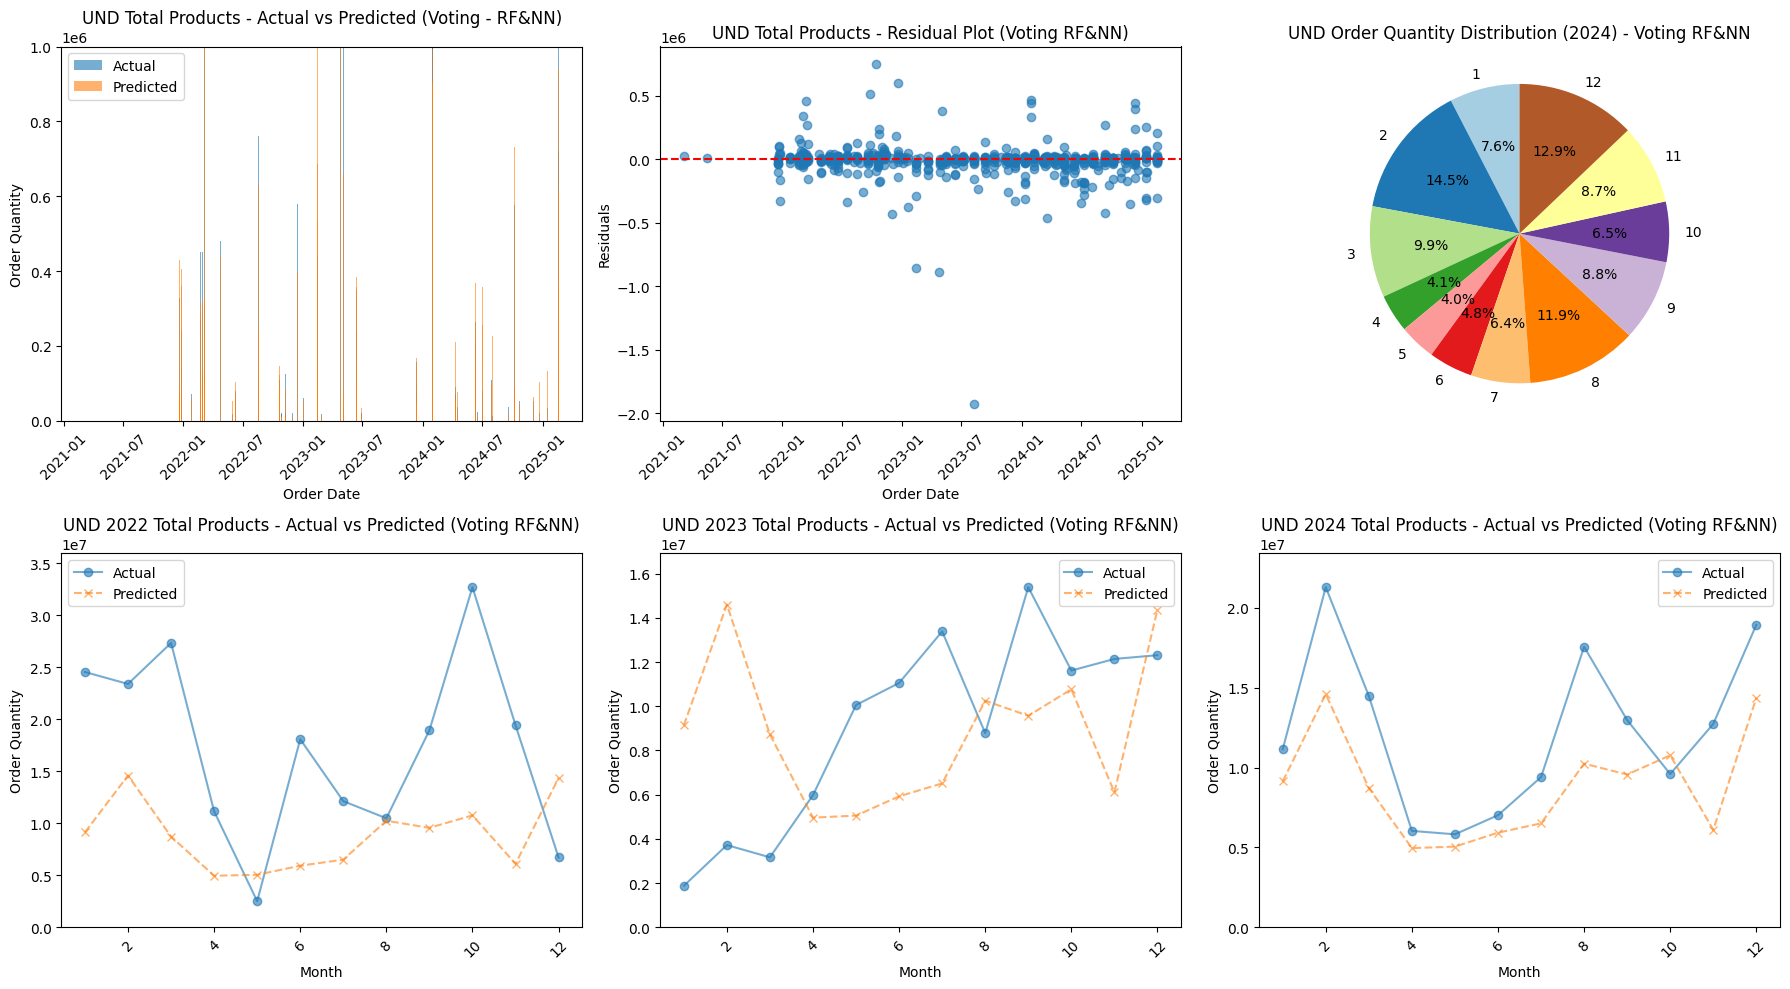

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a DetailedOrderDate column using week and weekday information.
df['DetailedOrderDate'] = pd.to_datetime(
    customer_total['order_year'].astype(str) +
    customer_total['order_week'].astype(str).str.zfill(2) +
    customer_total['order_weekday'].astype(str),
    format='%Y%W%w'
)

# Subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust layout for better spacing

# Bar plot: Actual vs. Predicted Order Quantity
axes[0, 0].bar(df.loc[y_val.index, 'DetailedOrderDate'], y_val, label='Actual', alpha=0.6)
axes[0, 0].bar(df.loc[y_val.index, 'DetailedOrderDate'], y_pred_rf_nn_voting, label='Predicted', alpha=0.6)
axes[0, 0].set_xlabel('Order Date')
axes[0, 0].set_ylabel('Order Quantity')
axes[0, 0].set_title(f'{custom_ref} Total Products - Actual vs Predicted (Voting - RF&NN)')
axes[0, 0].set_ylim(0, 1_000_000)
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Residual Plot
residuals = y_val - y_pred_rf_nn_voting
axes[0, 1].scatter(df.loc[y_val.index, 'DetailedOrderDate'], residuals, alpha=0.6)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Order Date')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title(f'{custom_ref} Total Products - Residual Plot (Voting RF&NN)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Pie Chart: Order Quantity per Month (2024)
order_2024 = df[df['order_year'] == 2024].groupby('order_month')['OrderQuantity'].sum()
axes[0, 2].pie(order_2024, labels=order_2024.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[0, 2].set_title(f'{custom_ref} Order Quantity Distribution (2024) - Voting RF&NN')

# Line Plots: Yearly Trends
for i, year in enumerate([2022, 2023, 2024]):  
    yearly_df = df[df['order_year'] == year]

    if yearly_df.empty:
        continue  # skip if no data for that year

    # Aggregate OrderQuantity per month
    monthly_actual = yearly_df.groupby('order_month')['OrderQuantity'].sum()

    # Convert total_y_pred_rf to Pandas Series with index from customer_total
    pred_series = pd.Series(y_pred_rf_nn_voting, index=y_val.index)

    # Group predictions by month
    monthly_predicted = pred_series.groupby(df.loc[y_val.index, 'order_month']).sum()

    # Sort for proper plotting
    monthly_actual = monthly_actual.sort_index()
    monthly_predicted = monthly_predicted.reindex(monthly_actual.index)  # Ensure same months

    # Plot actual and predicted values for the year
    axes[1, i].plot(monthly_actual.index, monthly_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
    axes[1, i].plot(monthly_predicted.index, monthly_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')

    axes[1, i].set_xlabel('Month')
    axes[1, i].set_ylabel('Order Quantity')
    axes[1, i].set_title(f'{custom_ref} {year} Total Products - Actual vs Predicted (Voting RF&NN)')
    axes[1, i].set_ylim(0, max(monthly_actual.max(), monthly_predicted.max()) * 1.1)  # Scale Y axis
    axes[1, i].legend()
    axes[1, i].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()
